In [1]:
!pip -q install simpy

import random
import numpy as np
import pandas as pd
import simpy

from dataclasses import dataclass
from typing import Dict, Tuple

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [2]:
@dataclass
class QueueParams:
    arrival_rate: float
    service_rate: float
    capacity: int
    sim_time: int
    warmup_time: int

def exponential_time(rate: float) -> float:

    return random.expovariate(rate)

def run_mm1k_simulation(p: QueueParams) -> Dict[str, float]:


    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)


    num_in_system = 0

    arrived = 0
    dropped = 0
    served = 0

    busy_time = 0.0
    last_busy_start = None


    wait_times = []
    system_times = []

    def customer(i: int, arrival_t: float):
        nonlocal num_in_system, served, busy_time, last_busy_start

        with server.request() as req:

            yield req
            start_service_t = env.now


            if arrival_t >= p.warmup_time:
                wait_times.append(start_service_t - arrival_t)


            if last_busy_start is None:
                last_busy_start = start_service_t

            service_t = exponential_time(p.service_rate)
            yield env.timeout(service_t)
            end_t = env.now


            if arrival_t >= p.warmup_time:
                system_times.append(end_t - arrival_t)

            served += 1
            num_in_system -= 1


            if server.count == 0 and len(server.queue) == 0:
                if last_busy_start is not None:
                    busy_time += (end_t - last_busy_start)
                    last_busy_start = None

    def arrival_process():
        nonlocal num_in_system, arrived, dropped

        i = 0
        while env.now < p.sim_time:
            inter_arrival = exponential_time(p.arrival_rate)
            yield env.timeout(inter_arrival)

            t = env.now
            arrived += 1


            if num_in_system >= p.capacity:
                dropped += 1
                continue

            num_in_system += 1
            i += 1
            env.process(customer(i, t))

    env.process(arrival_process())
    env.run(until=p.sim_time)


    if last_busy_start is not None:
        busy_time += (p.sim_time - last_busy_start)

    effective_time = max(1.0, p.sim_time - p.warmup_time)
    utilization = busy_time / p.sim_time
    throughput = served / p.sim_time
    drop_rate = dropped / arrived if arrived > 0 else 0.0

    avg_wait = float(np.mean(wait_times)) if wait_times else 0.0
    avg_system = float(np.mean(system_times)) if system_times else 0.0

    return {
        "avg_wait_time": avg_wait,
        "avg_system_time": avg_system,
        "utilization": utilization,
        "throughput": throughput,
        "drop_rate": drop_rate,
        "arrived": arrived,
        "served": served,
        "dropped": dropped,
    }


In [3]:
def sample_params() -> QueueParams:
    arrival_rate = random.uniform(0.2, 5.0)
    service_rate = random.uniform(0.3, 6.0)
    capacity = random.randint(5, 100)
    sim_time = random.randint(300, 2000)
    warmup_time = random.randint(0, min(200, sim_time // 2))
    return QueueParams(arrival_rate, service_rate, capacity, sim_time, warmup_time)

N = 1000

rows = []
for _ in range(N):
    p = sample_params()
    out = run_mm1k_simulation(p)
    row = {
        "arrival_rate": p.arrival_rate,
        "service_rate": p.service_rate,
        "capacity": p.capacity,
        "sim_time": p.sim_time,
        "warmup_time": p.warmup_time,
        **out
    }
    rows.append(row)

df = pd.DataFrame(rows)
df.head()


,arrival_rate,service_rate,capacity,sim_time,warmup_time,avg_wait_time,avg_system_time,utilization,throughput,drop_rate,arrived,served,dropped
0,3.269249,0.442561,40,801,57,96.648317,99.204176,0.999943,0.401998,0.864369,2669,322,2307
1,1.885910,2.439481,66,1915,147,2.003590,2.411002,0.999709,1.918538,0.000000,3674,3674,0
2,1.627273,2.244368,77,1360,134,1.181995,1.633360,0.999608,1.626471,0.000000,2212,2212,0
3,3.662008,4.788027,74,398,155,1.092741,1.320136,0.997453,3.535176,0.000000,1409,1407,0
4,4.175866,4.755760,33,1901,90,1.130507,1.336550,0.999968,4.158864,0.000126,7907,7906,1


In [4]:
df.to_csv("simpy_mm1k_dataset.csv", index=False)
print("Saved simpy_mm1k_dataset.csv with shape:", df.shape)


Saved simpy_mm1k_dataset.csv with shape: (1000, 13)


       arrival_rate  service_rate     capacity     sim_time  warmup_time  \
count   1000.000000   1000.000000  1000.000000  1000.000000   1000.00000   
mean       2.606510      3.205917    53.483000  1145.217000     99.48100   
std        1.351690      1.629657    27.700163   491.128147     58.45289   
min        0.202793      0.302275     5.000000   302.000000      0.00000   
25%        1.478028      1.772194    30.000000   719.500000     48.00000   
50%        2.584632      3.276200    53.000000  1163.500000    101.00000   
75%        3.762102      4.663111    78.000000  1571.500000    150.00000   
max        4.978849      5.996063   100.000000  1998.000000    200.00000   

       avg_wait_time  avg_system_time  utilization   throughput    drop_rate  \
count    1000.000000      1000.000000  1000.000000  1000.000000  1000.000000   
mean       17.202646        17.714480     0.999273     1.966831     0.175126   
std        36.653318        37.095842     0.001450     1.186644     0.27098

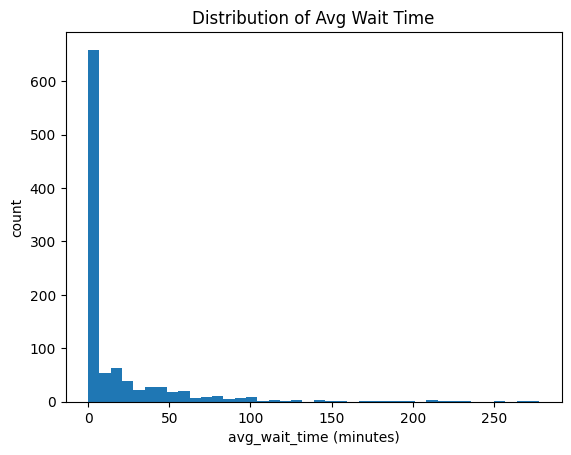

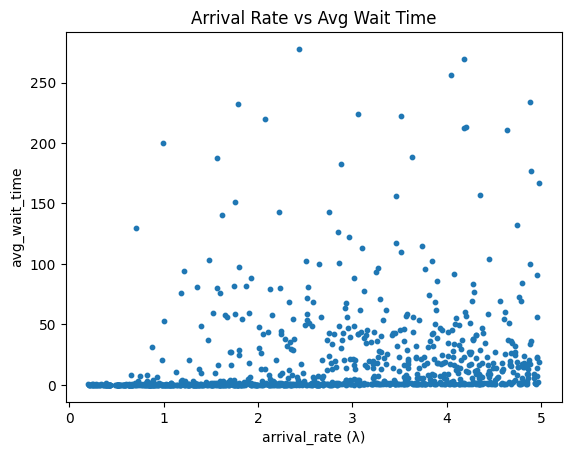

In [5]:
print(df.describe())

plt.figure()
plt.hist(df["avg_wait_time"], bins=40)
plt.title("Distribution of Avg Wait Time")
plt.xlabel("avg_wait_time (minutes)")
plt.ylabel("count")
plt.show()

plt.figure()
plt.scatter(df["arrival_rate"], df["avg_wait_time"], s=10)
plt.title("Arrival Rate vs Avg Wait Time")
plt.xlabel("arrival_rate (λ)")
plt.ylabel("avg_wait_time")
plt.show()


In [6]:
target = "avg_wait_time"
feature_cols = ["arrival_rate", "service_rate", "capacity", "sim_time", "warmup_time"]

X = df[feature_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "KNN": KNeighborsRegressor(n_neighbors=10),
    "SVR(RBF)": SVR(C=10.0, gamma="scale"),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=SEED),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=300, random_state=SEED),
    "GradientBoosting": GradientBoostingRegressor(random_state=SEED),
    "AdaBoost": AdaBoostRegressor(random_state=SEED),
}

def eval_on_test(model, scale: bool) -> Dict[str, float]:
    if scale:
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    else:
        pipe = Pipeline([("model", model)])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred) ** 0.5
    r2 = r2_score(y_test, pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

results = []
for name, model in models.items():

    scale = name.startswith("SVR") or name == "KNN" or name in ["Ridge", "Lasso", "ElasticNet", "LinearRegression"]
    metrics = eval_on_test(model, scale=scale)
    results.append({"Model": name, **metrics})

res_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True)
res_df


,Model,MAE,RMSE,R2
7,ExtraTrees,2.459919,7.890344,0.953270
8,GradientBoosting,4.434125,8.431004,0.946646
6,RandomForest,3.026897,8.684190,0.943394
9,AdaBoost,10.889612,13.983206,0.853236
5,SVR(RBF),6.892014,23.093863,0.599686
4,KNN,8.569175,24.219266,0.559720
1,Ridge,18.782585,29.632151,0.340927
3,ElasticNet,18.790209,29.634136,0.340839
2,Lasso,18.795181,29.635423,0.340781
0,LinearRegression,18.795881,29.635686,0.340770


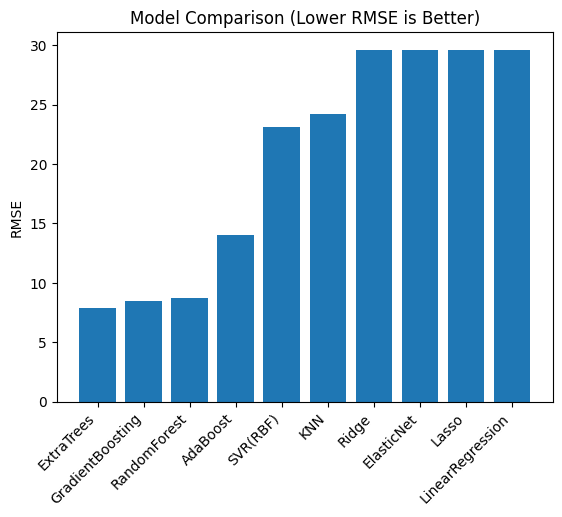

In [7]:
plt.figure()
plt.bar(res_df["Model"], res_df["RMSE"])
plt.title("Model Comparison (Lower RMSE is Better)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.show()


In [8]:
best_row = res_df.iloc[0]
best_row


,7
Model,ExtraTrees
MAE,2.459919
RMSE,7.890344
R2,0.95327


In [9]:
res_df.to_csv("model_comparison.csv", index=False)
print("Saved model_comparison.csv")


Saved model_comparison.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')